# Disease biomarkers for nervous system diseases

This notebook allows to investigate correlations between genomic and proteomic biomarkers and diseases of your interest. The underlying biomarker data is coming from the normalized indexing of databases such as ClinicalTrials.gov, ClinVar, Cosmic, GWAS, OMIM, but also text data from Medline, PubMed Central, Embase, Medmeme and patents that resides in proprietary OntoChem DB tables. It represents the largest data set on biomarkers and disease correlations.

The notebook shall demonstrate possibilities of data analytics with Kaggle notebooks and ontology based semantic data - showing interesting correlations between diseases based on their biomarkers.

In [1]:
import pandas as pd
from pandas import crosstab
import matplotlib.pyplot as plt
import seaborn as sns

## Connect to the Biomarker project
The OntoChem biomarker project stores data in its own BigQuery (BQ) tables. This technology allows any user with appropriate permissions from OntoChem to access the data and use it for any data analytics - using programmatic access via the BQ API or other tools like Looker or Kaggle. When using Kaggle, no individual Google BQ user account is required to access the tables. 

In [2]:
PROJECT_ID = 'biomarker'
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

## Select a disease concept or class

You can select a disease concept or a class of diseases and their corresponding OCIDs (OntoChem's **O**ntology **C**oncept **ID**s) at: `https://sciwalker.com/` > `Search` > `Domain browser`

For this example we're going to search for biomarkers which target `Nervous System Diseases`, 
the corresponding concept has the OCID: `208000009025`

In [3]:
# change the OCID here
disease_ocid=208000009025

## Create a BQ query to fetch all biomarkers which target the `disease_ocid` class and all respective child concepts

The BQ query uses standard SQL statements. Please ask for access to the OntoChem biomarker project for table and column names if you would like to create different data analytics.

In [4]:
query = """
SELECT  mkr.termFields.biomarker AS marker, 
        mkr.conceptFields.biomarker AS marker_ocid, 
        mkr_pl_tbl.name AS marker_lbl,
        mkr.termFields.biomarker_target AS target, 
        mkr.conceptFields.biomarker_target AS target_ocid,
        tgt_pl_tbl.name AS target_lbl,
        termFields.source_id AS src_id,
        termFields.srcrep AS src_repo
FROM `biomarker.relationships.dbrel` mkr
INNER JOIN ( 
    SELECT DISTINCT ocid 
    FROM `biomarker.ontologies.diseases_ancestors` 
    WHERE parent_ocid = {ocid}
) nsd ON nsd.ocid = mkr.conceptFields.biomarker_target
LEFT JOIN `biomarker.ontologies.full_preflabel` mkr_pl_tbl ON mkr_pl_tbl.ocid = mkr.conceptFields.biomarker
LEFT JOIN `biomarker.ontologies.full_preflabel` tgt_pl_tbl ON tgt_pl_tbl.ocid = mkr.conceptFields.biomarker_target
WHERE mkr.conceptFields.biomarker_target IS NOT NULL
AND mkr.conceptFields.biomarker IS NOT NULL
""".format(ocid=disease_ocid)

query_job = client.query(query, location="US")  
df = query_job.to_dataframe()

### Create a concept label lookup table
Each concept such as a disease or a gene has a preferred label, this allows normalizing data from different sources that use different synonyms for the same concept.

In [5]:
pref_lbl_lut_df = df[["marker_ocid", "marker_lbl"]].rename(columns={'marker_lbl':'label', 'marker_ocid':'ocid'}).append(
    df[["target_ocid", "target_lbl"]].rename(columns={'target_lbl':'label', 'target_ocid':'ocid'}))

# create a dictionary (ocid->pref_label) using the data frame
pref_lbl_lut = dict(zip(pref_lbl_lut_df.ocid, pref_lbl_lut_df.label))

## Remove duplicate mentions from the same source

Unique biomarker disease pairs may appear multiple times in our data, e.g. if this relationship was mentionend multiple times in the same PubMedCentral article.
Because we want to count multiple mentions in the same document or data source only as one mention, we group the data by their `src_id`.

In [6]:
df_uniq_srcid = df.groupby(["target_ocid", "marker_ocid", "src_id"]).first().reset_index()

## Top 20 Biomarker disease pairs sorted by occurence count

Let's look at the top 20 biomarker-disease pairs with the most mentions on our data:

In [7]:
marker_tgt_counts = df_uniq_srcid.groupby(["target_ocid", "marker_ocid","target_lbl", "marker_lbl"]).size().reset_index(name='counts')
marker_tgt_counts.sort_values(by=["counts"], ascending=False).head(20)

,target_ocid,marker_ocid,target_lbl,marker_lbl,counts
39285,206010003594,102100000648,Ataxia telangiectasia,ATM,7064
102889,208000005068,102100008210,Tuberous Sclerosis 2,TSC2,2105
95290,208000003019,102100018369,Neurofibromatosis 1,NF1,1858
91204,208000001826,102100009074,Marfan Syndrome,FBN1,1851
110918,208000007701,102100002479,Epidermolysa bullosa simplex and limb girdle m...,PLEC,1431
83640,206010062804,102100007268,Basal cell naevus syndrome,PTCH1,1374
42661,206010008025,102100010087,Cerebellar ataxia,SYNE1,1321
61175,206010018338,102100019730,Glioma,TP53,1315
84719,206010068783,102100010082,Alstroem syndrome,ALMS1,1293
112581,208000008315,102100017459,Nemaline Myopathy 2,NEB,1237


## Biomarker disease co-occurrences
Let's look how often the most occurring markers appear together with the most occuring diseases.

To achieve this, we calculate two measurements of occurrence:
1. promiscuity counts: for each marker how many different diseases it targets and vice versa. This reflects the selectivity of a given biomarker for a disease - the lower the promiscuity count of a biomarker, the higher the selectivity for a disease.
2. appearence counts: for each marker how often it is mentioned together with any target and vice versa.

To visualize these co-occurencens we created a crosstab for counting the biomarker disease pairs and a heatmap for visualization.

### Top 30 promiscuous biomarkers and diseases
The correlation shows that Interleukin 6 (IL-6) is the most promiscuous and thus the most disease unselective biomarker:

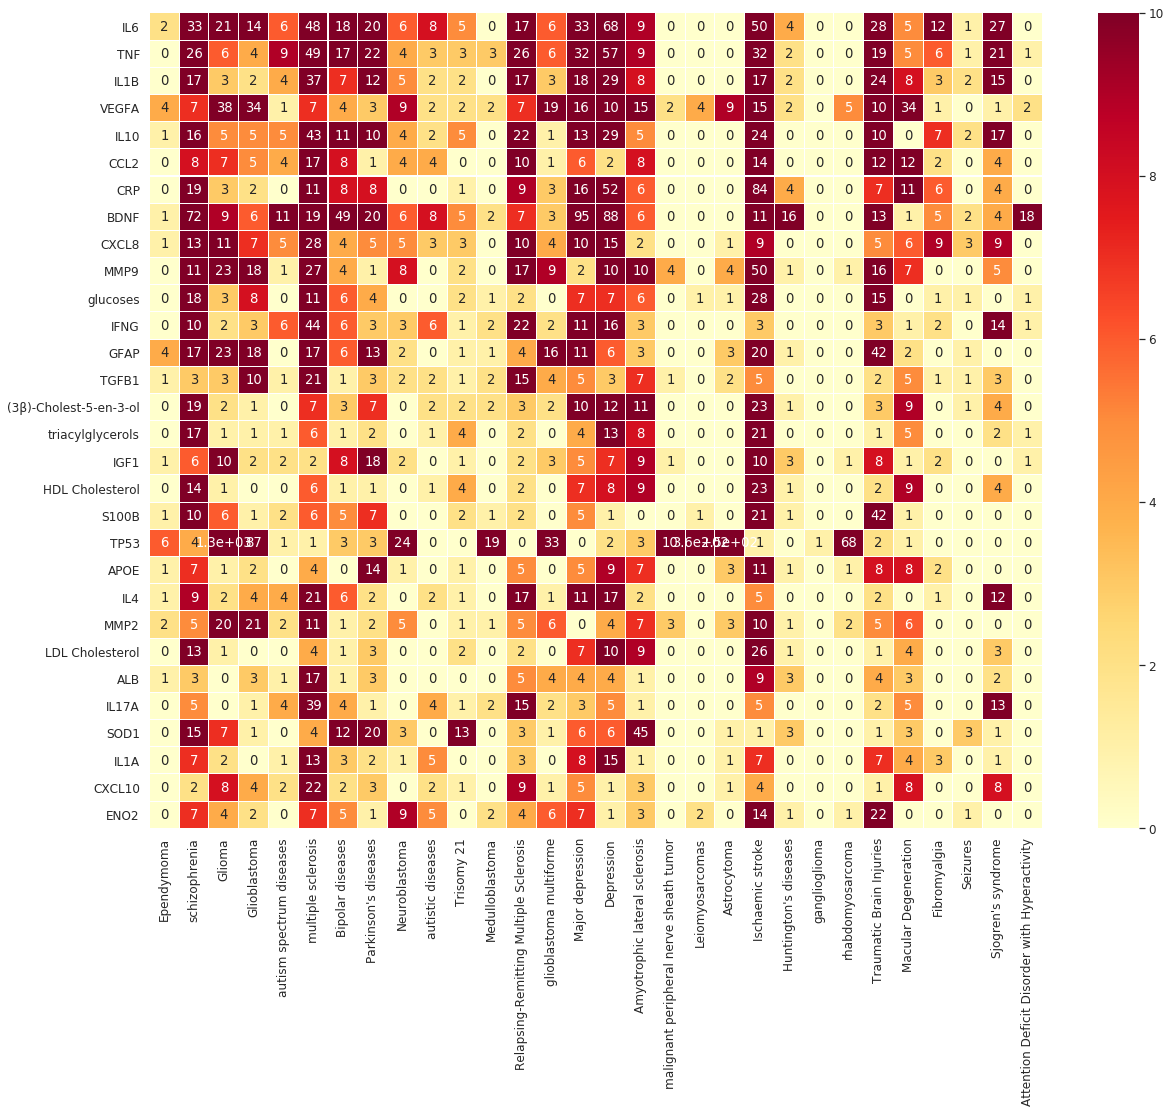

In [8]:
# get the top 30 most promiscuous markers respective diseases
most_promiscuous_markers = df_uniq_srcid[["marker_ocid", "target_ocid"]].drop_duplicates()["marker_ocid"].value_counts().index.tolist()[:30]
most_promiscuous_targets = df_uniq_srcid[["marker_ocid", "target_ocid"]].drop_duplicates()["target_ocid"].value_counts().index.tolist()[:30]
df_most_promiscuous_biomarkers = df_uniq_srcid[df_uniq_srcid.marker_ocid.isin(most_promiscuous_markers) & df_uniq_srcid.target_ocid.isin(most_promiscuous_targets)]

# create a frequency table
tab_most_promiscuous_biomarkers = crosstab(index=df_most_promiscuous_biomarkers['marker_ocid'], columns=df_most_promiscuous_biomarkers['target_ocid'])

# resort the table by most promiscuous target and markers
tab_most_promiscuous_biomarkers = tab_most_promiscuous_biomarkers[most_promiscuous_targets]
tab_most_promiscuous_biomarkers = tab_most_promiscuous_biomarkers.reindex(index=most_promiscuous_markers)

# set the pref labels 
tab_most_promiscuous_biomarkers.columns = [pref_lbl_lut[i] for i in tab_most_promiscuous_biomarkers.columns]
tab_most_promiscuous_biomarkers.index = [pref_lbl_lut[i] for i in tab_most_promiscuous_biomarkers.index]

# plot the heat map
sns.set(font_scale=1.1) 
fig, (ax) = plt.subplots(1, 1, figsize=(20,15))
hm = sns.heatmap(tab_most_promiscuous_biomarkers, ax=ax, cmap="YlOrRd", annot=True, vmin=0, vmax=10, linewidths=.05)

### Top 30 appearing biomarkers and diseases

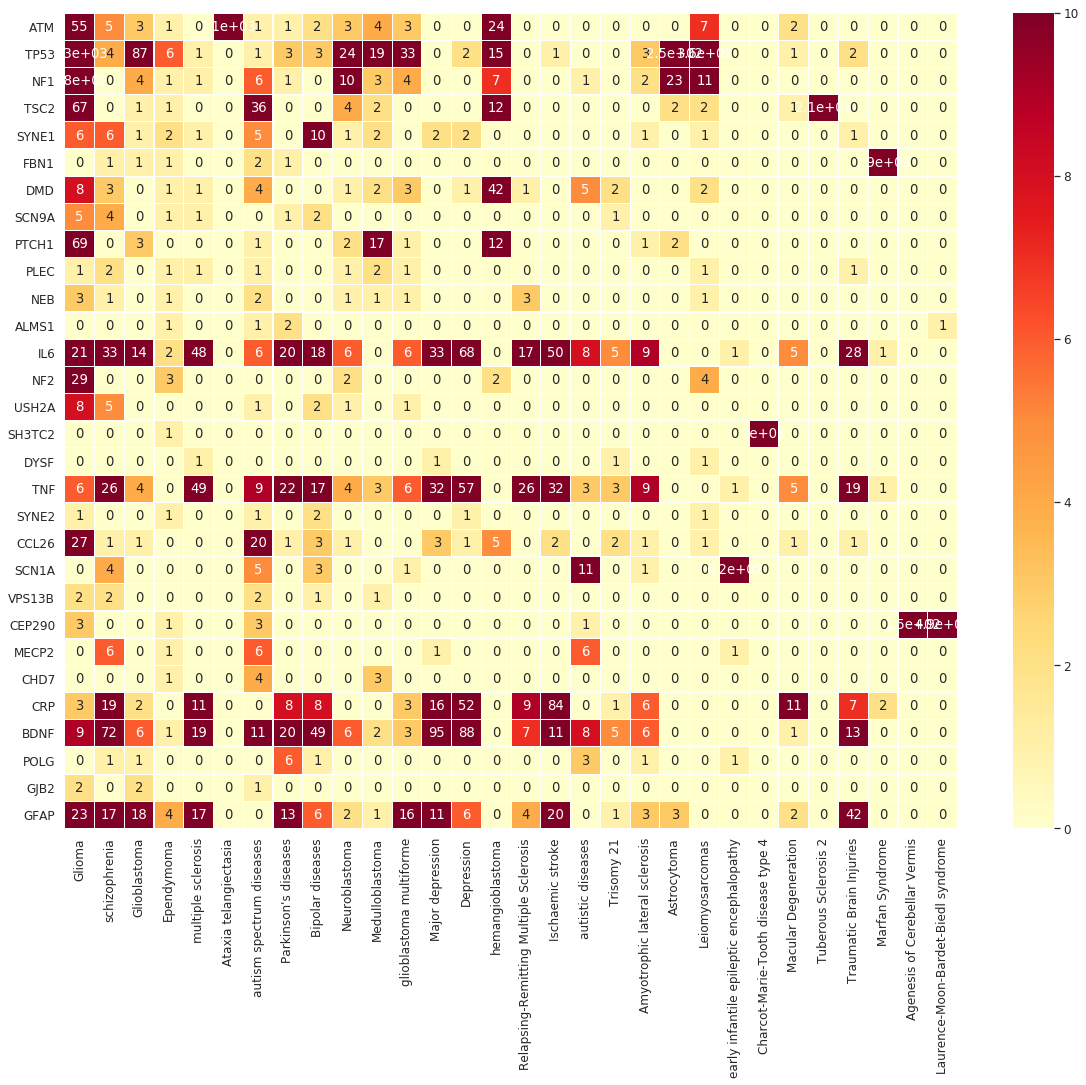

In [9]:
# get the top 30 most appearing markers respective diseases
most_appearing_markers = df_uniq_srcid["marker_ocid"].value_counts().index.tolist()[:30]
most_appearing_targets = df_uniq_srcid["target_ocid"].value_counts().index.tolist()[:30]
df_most_appearing_biomarkers = df_uniq_srcid[df_uniq_srcid.marker_ocid.isin(most_appearing_markers) & df_uniq_srcid.target_ocid.isin(most_appearing_targets)]

# create a frequency table
tab_most_appearing_biomarkers = crosstab(index=df_most_appearing_biomarkers['marker_ocid'], columns=df_most_appearing_biomarkers['target_ocid'])

# resort the table by most appearing target and markers
tab_most_appearing_biomarkers = tab_most_appearing_biomarkers[most_appearing_targets]
tab_most_appearing_biomarkers = tab_most_appearing_biomarkers.reindex(index=most_appearing_markers)

# set the pref labels 
tab_most_appearing_biomarkers.index = [pref_lbl_lut[i] for i in tab_most_appearing_biomarkers.index]
tab_most_appearing_biomarkers.columns = [pref_lbl_lut[i] for i in tab_most_appearing_biomarkers.columns]

# plot the heat map
sns.set(font_scale=1.1) 
fig, (ax) = plt.subplots(1, 1, figsize=(20,15))
hm = sns.heatmap(tab_most_appearing_biomarkers, ax=ax, cmap="YlOrRd", annot=True, vmin=0, vmax=10, linewidths=.05)

### Cluster biomarkers with similar disease targets and vice versa

In this part we're going to cluster biomarker-disease co-occurrences. Thus, we cluster  diseases together that are targeted by the same biomarkers and cluster biomarkers that target the same diseases.
To do so, we define a minimal counts cutoff above which we consider a biomarker diseases pair as valid. All pairs that have a count above this cutoff get a one and all counts
below this cutoff get a zero in the correlation matrix. This is done for both occurrence measurements.

In [10]:
# number of biomarker diseases pair count to be seen as evident.
cutoff = 3

#### Most promiscuous biomarkers and diseases cluster

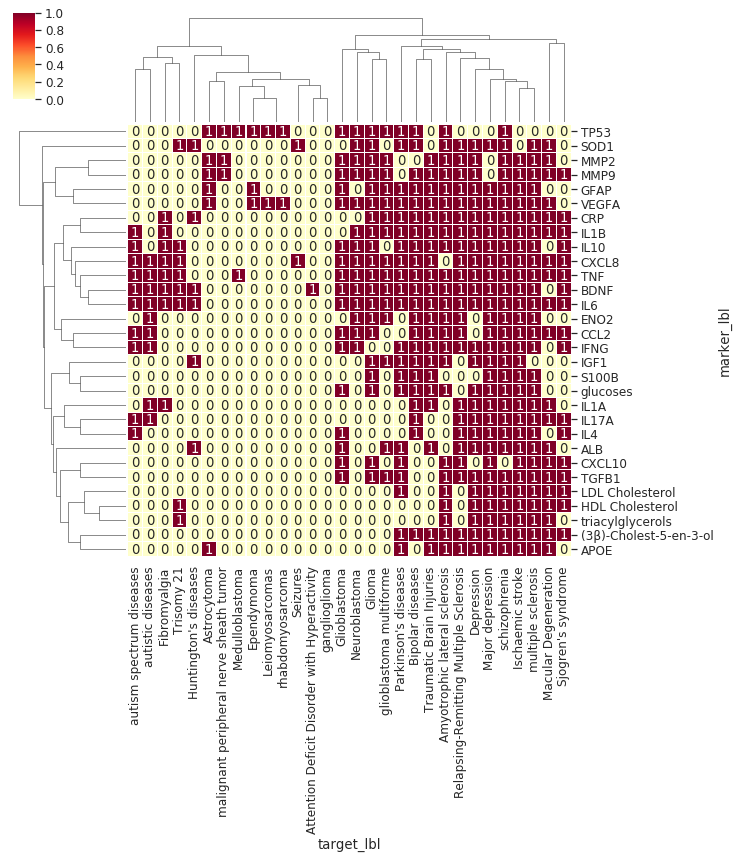

In [11]:
tab_most_promiscuous_biomarkers_clustr = crosstab(index=df_most_promiscuous_biomarkers['marker_lbl'], columns=df_most_promiscuous_biomarkers['target_lbl'])
tab_most_promiscuous_biomarkers_clustr[tab_most_promiscuous_biomarkers_clustr < cutoff] = 0
tab_most_promiscuous_biomarkers_clustr[tab_most_promiscuous_biomarkers_clustr >= cutoff] = 1

sns.set(font_scale=1.1) 
cm = sns.clustermap(tab_most_promiscuous_biomarkers_clustr, method='average', metric='euclidean', cmap="YlOrRd", annot=True, vmin=0, vmax=1, linewidths=.05)

#### Most appearing biomarkers and diseases cluster

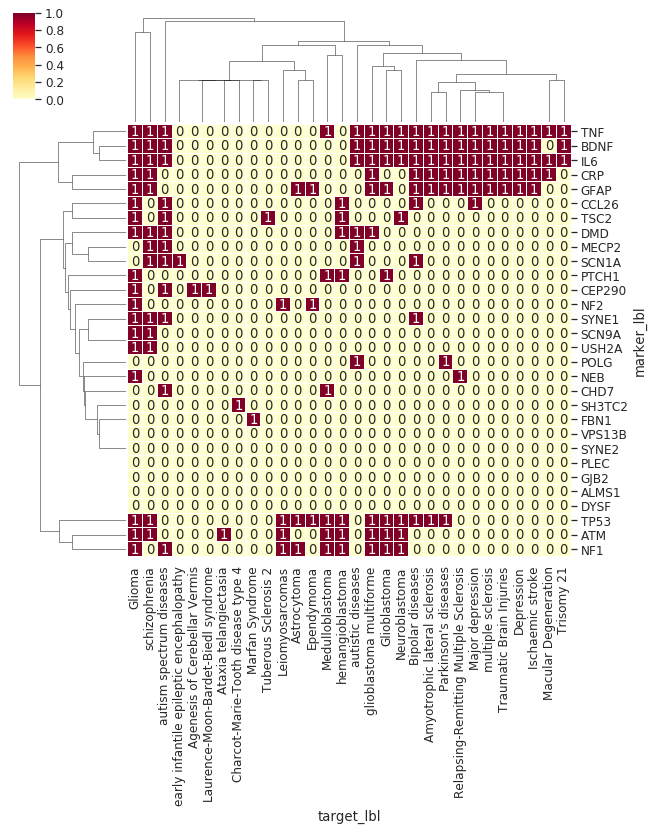

In [12]:
tab_most_appearing_biomarkers_clustr = crosstab(index=df_most_appearing_biomarkers['marker_lbl'], columns=df_most_appearing_biomarkers['target_lbl'])
tab_most_appearing_biomarkers_clustr[tab_most_appearing_biomarkers_clustr < cutoff] = 0
tab_most_appearing_biomarkers_clustr[tab_most_appearing_biomarkers_clustr >= cutoff] = 1

sns.set(font_scale=1.1) 
cm = sns.clustermap(tab_most_appearing_biomarkers_clustr, method='average', metric='euclidean', cmap="YlOrRd", annot=True, vmin=0, vmax=1, linewidths=.05)

The clustering in the correlated most frequent biomarker-diseases shows that diseases schizophrenia and glioma share many of the same biomarkes - is this creating the hypothesis that both diseases share some common mechanisms?
In any case, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6129591/ advances data that glioma is more likely for people with schizophrenia. 